In [7]:
import io
from datetime import date, timedelta

import xarray as xr
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean

# Not used directly, but used via xarray
import cfgrib

In [7]:
# Constants for creating the full URL
blob_container = "https://noaahrrr.blob.core.windows.net/hrrr"
sector = "conus"
yesterday = date.today() - timedelta(days=1)
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

# Put it all together
file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"{blob_container}/hrrr.{yesterday:%Y%m%d}/{sector}/{file_path}"

print(url)

https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20230213/conus/hrrr.t12z.wrfsfcf01.grib2


In [12]:
# Fetch the idx file by appending the .idx file extension to our already formatted URL
r = requests.get(f"{url}.idx")
idx = r.text.splitlines()

# Take a peek at the content of the index
print(*idx[0:10], sep="\n")

1:0:d=2023021312:REFC:entire atmosphere:1 hour fcst:
2:292385:d=2023021312:RETOP:cloud top:1 hour fcst:
3:400963:d=2023021312:var discipline=0 center=7 local_table=1 parmcat=16 parm=201:entire atmosphere:1 hour fcst:
4:754867:d=2023021312:VIL:entire atmosphere:1 hour fcst:
5:943788:d=2023021312:VIS:surface:1 hour fcst:
6:2466056:d=2023021312:REFD:1000 m above ground:1 hour fcst:
7:2627906:d=2023021312:REFD:4000 m above ground:1 hour fcst:
8:2696411:d=2023021312:REFD:263 K level:1 hour fcst:
9:2815148:d=2023021312:GUST:surface:1 hour fcst:
10:4179718:d=2023021312:UGRD:250 mb:1 hour fcst:


In [16]:
idx[63]

'64:41265764:d=2023021312:TMP:surface:1 hour fcst:'

In [14]:
# You can see it has a 1-indexed base line number, staring byte position, date, variable, atmosphere level,
# and forecast description. The lines are colon-delimited. 

# Let's grab surface temperature `TMP:surface`.
sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
print("Surface temp line:", sfc_temp_idx)

# Pluck the byte offset from this line, plus the beginning offset of the next line
line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

# The line number values are 1-indexed, so we don't need to increment it to get the next list index,
# but check we're not already reading the last line
next_line = idx[line_num].split(':') if line_num < len(idx) else None

# Pluck the start of the next byte offset, or nothing if we were on the last line
range_end = next_line[1] if next_line else None

print(f"Byte range: {range_start}-{range_end}")

Surface temp line: ['64', '41265764', 'd=2023021312', 'TMP', 'surface', '1 hour fcst', '']
Byte range: 41265764-42715051


In [17]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

In [18]:
ds = xr.open_dataset(file.name, engine='cfgrib', 
                     backend_kwargs={'indexpath':''})

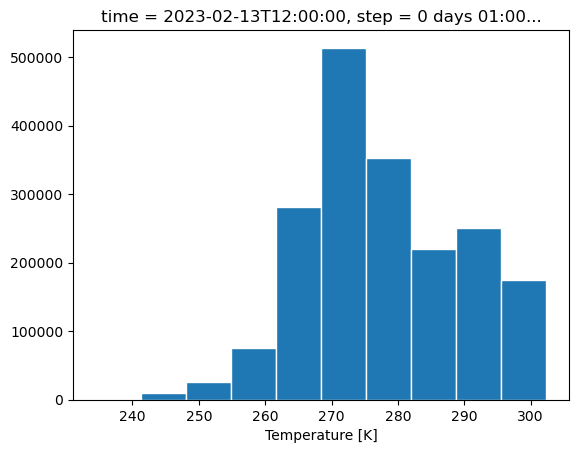

In [19]:
ds.t.plot.hist(edgecolor="white")
plt.show()

In [20]:
attrs = ds.t.attrs

assert attrs['GRIB_gridType'] == 'lambert'

# Define the CRS with attributes from the temperate DataArray
prj_kwargs = dict(
    globe=ccrs.Globe(ellipse='sphere'),
    central_latitude=attrs['GRIB_LaDInDegrees'],
    central_longitude=attrs['GRIB_LoVInDegrees'],
    standard_parallels=(attrs['GRIB_Latin1InDegrees'],\
                        attrs['GRIB_Latin2InDegrees'])
)

prj = ccrs.LambertConformal(**prj_kwargs)

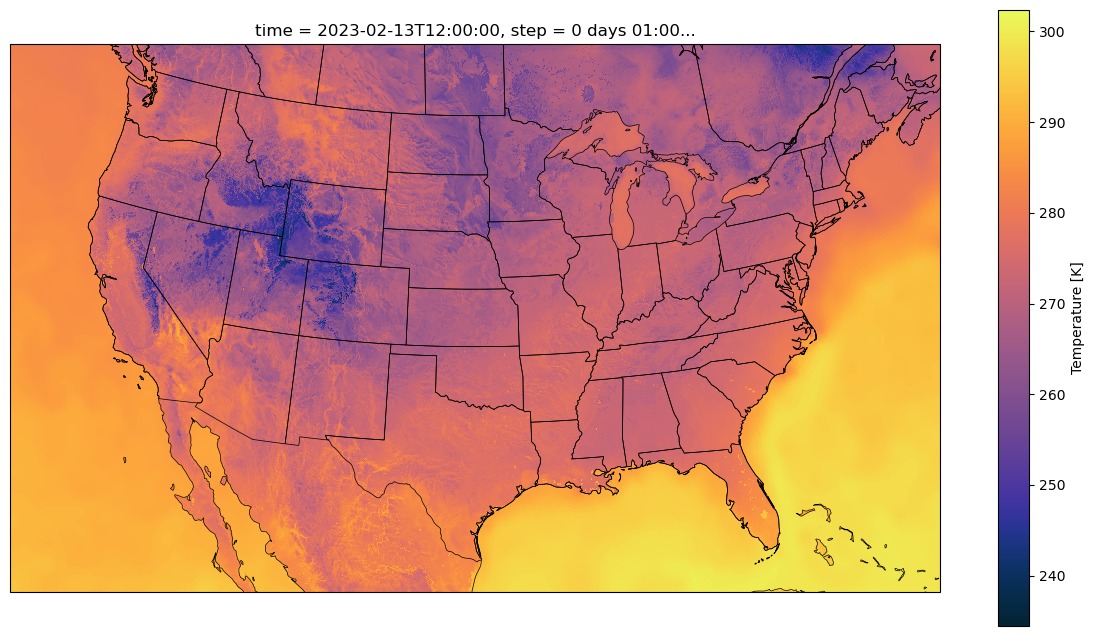

In [21]:
# Ignore some matplotlib deprecation warnings
import warnings; warnings.simplefilter("ignore")

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=prj)
plt_kwargs = dict(x='longitude', y='latitude', cmap=cmocean.cm.thermal, 
                  transform=ccrs.PlateCarree())

ds.t.plot(**plt_kwargs, ax=ax)
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
plt.show()

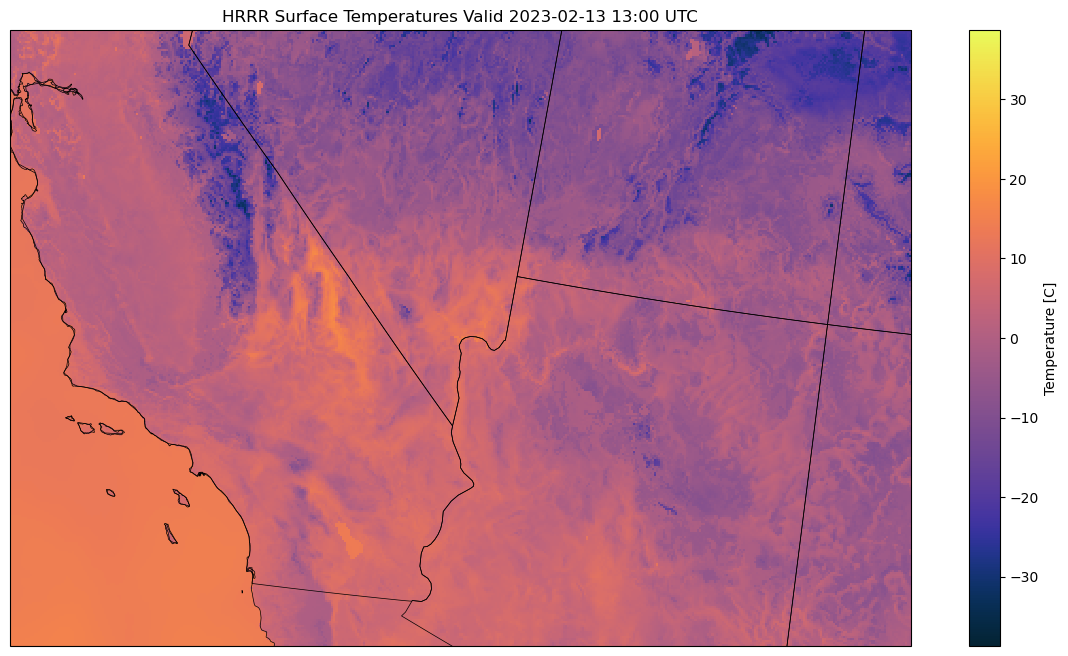

In [22]:
# Increase the dpi a bit for some crisper text
fig = plt.figure(figsize=(15,8), dpi=100)
ax = plt.axes(projection=prj)

# K to C
with xr.set_options(keep_attrs=True):
    t_c = ds.t - 273.15
    t_c.attrs["units"] = "C"

# Add some context and zoom to the SW
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.set_extent([-121, -108, 33, 39], crs=ccrs.PlateCarree())

t_c.plot(**plt_kwargs, ax=ax)
d = ds.coords['valid_time'].values

plt.title(f"HRRR Surface Temperatures Valid {yesterday} {cycle + forecast_hour:02}:00 UTC")
plt.show()

# Herbie
- https://herbie.readthedocs.io/en/latest/user_guide/_model_notebooks/hrrr.html
- https://herbie.readthedocs.io/en/latest/user_guide/_bonus_notebooks/nearest_points.html

In [12]:
from herbie import Herbie, FastHerbie
import pandas as pd
from pathlib import Path

In [9]:
H = Herbie(
    "2018-05-14",
    model="hrrr",
    product='sfc',
    fxx=0,
)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2018-May-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [10]:
ds = H.xarray("TMP:surface")
ds

<xarray.Dataset>
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2018-05-14
    step                 timedelta64[ns] 00:00:00
    surface              float64 0.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2018-05-14
Dimensions without coordinates: y, x
Data variables:
    t                    (y, x) float32 295.1 295.1 295.1 ... 275.0 274.9 275.0
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/keenansamway/data/hrrr/20180514/subset_76...
    searchString:            TMP:surface

In [5]:
points = [
    (-86.430867, 39.080319),
    (-121.51, 36.5597),
]
point_names = [
    "pt1",
    "pt2",
]

In [13]:
import warnings; warnings.simplefilter("ignore")

ds.herbie.nearest_points(points=points, names=point_names)

<xarray.Dataset>
Dimensions:              (point: 2)
Coordinates:
    time                 datetime64[ns] 2018-05-14
    step                 timedelta64[ns] 00:00:00
    surface              float64 0.0
    latitude             (point) float64 39.09 36.56
    longitude            (point) float64 273.6 238.5
    valid_time           datetime64[ns] 2018-05-14
    metpy_crs            object Projection: lambert_conformal_conic
    y                    (point) float64 1.227e+05 6.269e+04
    x                    (point) float64 9.535e+05 -2.122e+06
  * point                (point) <U3 'pt1' 'pt2'
Data variables:
    t                    (point) float32 287.4 297.1
    gribfile_projection  (point) object None None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/keenansamway/data/hrrr/20180514/subset_76...
    searchString:            TMP:surface